### carico dipendenze

In [52]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle
from skimage.registration import optical_flow_ilk, optical_flow_tvl1

try:
    import ot

except ModuleNotFoundError:
    path = Path(os.environ['USERPROFILE']) / "paracelso_wp32"
    assert path.exists()
    sys.path.append(str(path))

from ot.algoritmi import (OpenCVOpticalFlow, SkiOpticalFlowILK,
                          SkiOpticalFlowTVL1)
from ot.interfaces import Image
from ot import utils as otu
from ot.image_processing.common import np2cv
from ot.image_processing import common as img_common
import ot

In [9]:
import logging

logger = logging.getLogger(ot.__name__)

algorithm = OpenCVOpticalFlow()
ar1 = np.random.normal(size=(477, 541))
ar2 = np.random.normal(size=(477, 541))
_ar1 = Image(ar1, None, None)
_ar2 = Image(ar2, None, None)
prep_arrays = [_ar1, _ar2]

# m = plt.imshow(algorithm(*prep_arrays).image)
# plt.colorbar(m, shrink = 0.5)


class EventDispatcher:
    def __init__(self):
        self.processes = dict()

    def register(self, name: str, process):
        if name not in self.processes:
            self.processes[name] = list()
        self.processes[name].append(process)

    def dispatch_event(self, name: str, *args, **kwargs):
        for process in self.processes[name]:
            return process(**kwargs)

algorithm(*prep_arrays)

2025.26.04-16:26:55 [ot.algoritmi.__call__ - 192][INFO] - Eseguo algoritmo cv2.calcOpticalFlowFarneback
2025.26.04-16:26:55 [ot.algoritmi.__call__ - 193][DEBUG] - reference.shape = (477, 541), reference.image.dtype = dtype('float64')
2025.26.04-16:26:55 [ot.algoritmi.__call__ - 194][DEBUG] - target.shape = (477, 541), target.image.dtype = dtype('float64')
2025.26.04-16:26:55 [ot.algoritmi.__call__ - 206][DEBUG] - Numero output: 477
2025.26.04-16:26:55 [ot.algoritmi.__call__ - 207][DEBUG] - Tipo output: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.nd

[[2.4234307e-05 2.2843666e-05 2.6432102e-05 ... 4.6223026e-06
  3.7370164e-06 3.1686432e-06]
 [2.9121387e-05 3.0015080e-05 3.9842875e-05 ... 1.7922697e-05
  1.6989286e-05 1.8069386e-05]
 [2.7641419e-05 2.7696828e-05 3.7899401e-05 ... 2.5196969e-05
  1.8267070e-05 1.8097882e-05]
 ...
 [2.3668799e-05 3.2230066e-05 4.2837306e-05 ... 5.1004401e-05
  3.4199238e-05 3.9053921e-05]
 [2.0213753e-05 2.7423204e-05 3.4175911e-05 ... 4.4432971e-05
  1.8439972e-05 2.1130967e-05]
 [1.1565240e-05 1.7586066e-05 2.3042187e-05 ... 3.0250607e-05
  1.5990821e-05 1.6577189e-05]]
None
None

In [ ]:
import argparse
import os
import sys
from importlib import reload
from itertools import product
from pathlib import Path

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import yaml
from geopandas import points_from_xy
from matplotlib.colors import LogNorm, PowerNorm
from numpy.lib.stride_tricks import as_strided
from rasterio import CRS
from rasterio.transform import Affine, AffineTransformer
from scipy.signal import convolve2d
from skimage.color import rgb2gray
from skimage.registration import phase_cross_correlation
from tqdm import tqdm




def get_corvara_dataset():
    path = "W:/SoLoMon/Siti/Corvara/DEM/" +\
        "LiDAR_HELICA_2019_2022/Elaborazioni_UNIMORE" +\
        "/IRIS_corvara_2022/Elaborazione_HSD_NCC"
    return dict(enumerate(Path(path).rglob("*.tif*")))


def get_output_dataset():
    path = "../output"
    return dict(enumerate(Path(path).rglob("*.tif*")))


def print_summary_statistics(array):
    print(f"\n{'<'*15}| STATS |{'>'*15}")
    print(f"              Mean: {np.mean(array): .3g}")
    print(f"            Median: {np.median(array): .3g}")
    print(f"Standard Deviation: {np.std(array): .3g}")
    print(f"           Minimum: {np.min(array): .3g}")
    print(f"           Maximum: {np.max(array): .3g}")
    print(f"   25th Percentile: {np.percentile(array, 25): .3g}")
    print(f"   75th Percentile: {np.percentile(array, 75): .3g}")


def get_pictures_files(pattern: str = "*.jp*"):
    root = os.environ['USERPROFILE']
    pictures_path = os.path.join(root, "Pictures")
    return dict(enumerate(Path(pictures_path).rglob(pattern)))


def get_png_images():
    return dict(enumerate(Path("C:\\Users\\vcritell\\Pictures\\").glob("*.png")))


def normalize_default(array):
    return cv2.normalize(array, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


def infer_nodata_mask(array: np.ndarray, use_max: bool = False) -> np.ndarray:
    vmin, vmax = np.percentile(array, [0.001, 99.999])

    if use_max:
        return array >= vmax
    else:
        return array <= vmin


def homogenize_nan(array, nodata, overwrite_nodata=None):
    array = array.copy()
    mask = (array == nodata).any(axis=2)
    new_nan = overwrite_nodata or nodata

    for i in range(array.shape[-1]):
        array[:, :, i][mask] = new_nan

    return array


def apply_mask(array, mask):
    return np.ma.masked_array(array, mask)

In [38]:
a = str(get_pictures_files(pattern='*png')[0])

with rasterio.open(a, "r") as ds:
    array = ds.read()

In [67]:
1032/1920

0.5375

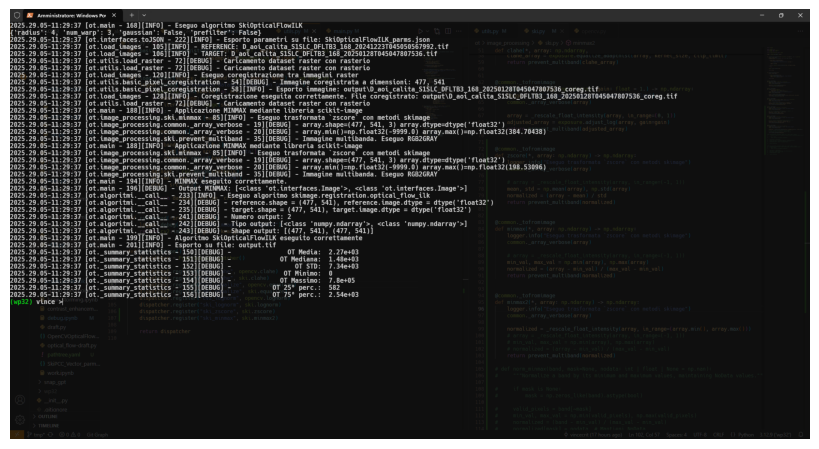

In [ ]:


inner = cv2.merge([*array[:, :, :]])
img = cv2.cvtColor(inner, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [408]:
cv2.imread("../output/D_BL_S1SLC_DFLT_168_20240720T045052590968.tif", cv2.IMREAD_LOAD_GDAL)

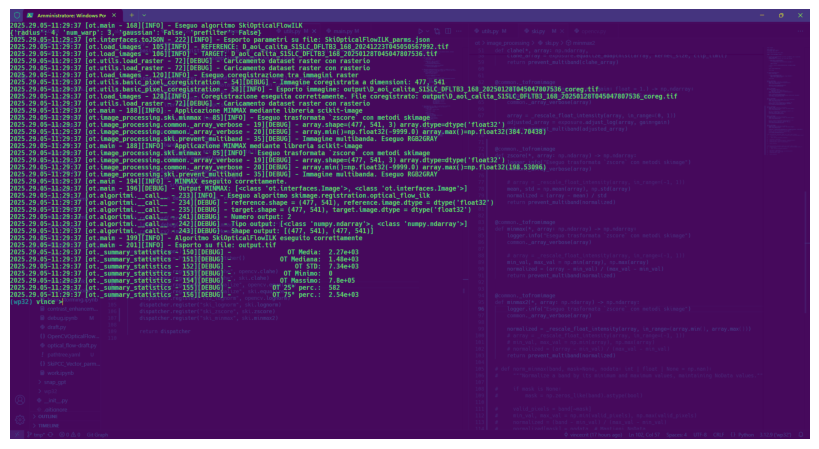

In [ ]:
def np_layout_to_cv2(array, ):
    alpha_band = None

    if array.ndim < 3:
        pass

    else:
        if array.shape[0] > 3:
            alpha_band = array[0, :, :].copy()
            array = array[:3, :, :]

        elif array.shape[0] == 2:
            b1, b2 = array
            array = np.stack([b1, b2, b2/b1])


    if not img_common._is_cv8u(array):
        array *= 1/255
        array = array.astype(np.uint8)

    stacked = np.stack([*array], axis=-1)
    return cv2.cvtColor(stacked, cv2.COLOR_RGBA2GRAY)


fig, ax = plt.subplots(figsize=(10.32, 19.20))
ax.axis('off')
plt.imshow(np_layout_to_cv2(array))

In [10]:
a = get_corvara_dataset()[0]

cv2.imread(a, cv2.IMREAD_LOAD_GDAL)

array([[[229, 229, 229],
        [234, 234, 234],
        [235, 235, 235],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[235, 235, 235],
        [235, 235, 235],
        [234, 234, 234],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[236, 236, 236],
        [233, 233, 233],
        [231, 231, 231],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]